In [164]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Layer, ReLU, LeakyReLU
from tensorflow.keras import backend as K
import time

In [165]:
from func import load_model, save_model

Load bkg and signals

In [166]:
filename = './BKG_OH2_OH_dataset.h5'
# make sure input data has correct input shape - background training data
with h5py.File(filename, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])


In [167]:
# add correct signal labels
signal_labels = ['Ato4l_lepFilter_13TeV_dataset',
                 'hChToTauNu_13TeV_PU20_dataset',
                 'hToTauTau_13TeV_PU20_dataset',
                 'leptoquark_LOWMASS_lepFilter_13TeV_dataset']

In [168]:
# add correct path to signal files
signals_file = ['./Ato4l_lepFilter_13TeV_input_OH_dataset.h5',
                './hChToTauNu_13TeV_PU20_input_OH_dataset.h5',
                './hToTauTau_13TeV_PU20_input_OH_dataset.h5',
                './leptoquark_LOWMASS_lepFilter_13TeV_input_OH_dataset.h5']

In [169]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file['Data'])
    signal_data.append(test_data)

Define structure

In [170]:
input_shape = 152
latent_dimension = 3
num_nodes=[16,8]

In [171]:
#encoder
inputArray = Input(shape=(input_shape))
x = Dense(num_nodes[0], use_bias=False)(inputArray)
x = Activation('relu')(x)
x = Dense(latent_dimension, use_bias=False)(x)
encoder = Activation('relu')(x)

#decoder
x = Dense(num_nodes[0], use_bias=False)(encoder)
x = Activation('relu')(x)
decoder = Dense(input_shape)(x)

#create autoencoder
autoencoder = Model(inputs = inputArray, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 152)]             0         
                                                                 
 dense_4 (Dense)             (None, 16)                2432      
                                                                 
 activation_3 (Activation)   (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 48        
                                                                 
 activation_4 (Activation)   (None, 3)                 0         
                                                                 
 dense_6 (Dense)             (None, 16)                48        
                                                                 
 activation_5 (Activation)   (None, 16)                0   

In [172]:
autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')

Train AE

In [173]:
EPOCHS = 10
BATCH_SIZE = 1024

In [174]:
history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val))

Epoch 1/10
2500/2500 [==============================] - 9s 3ms/step - loss: 3.3039 - val_loss: 1.6968
Epoch 2/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.9938 - val_loss: 0.7234
Epoch 3/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.7034 - val_loss: 0.7026
Epoch 4/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.6949 - val_loss: 0.6995
Epoch 5/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.6890 - val_loss: 0.6923
Epoch 6/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.6839 - val_loss: 0.7008
Epoch 7/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.6800 - val_loss: 0.6804
Epoch 8/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.6750 - val_loss: 0.6799
Epoch 9/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.6710 - val_loss: 0.6715
Epoch 10/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.667

In [175]:
model_name = 'DENSE_AE_OH1_model'
model_directory = './models'
save_model(model_directory+model_name, autoencoder)

In [176]:
# add correct signal labels
data_labels  = ['Ato4l_lepFilter_13TeV_output',
                 'hChToTauNu_13TeV_PU20_output',
                 'hToTauTau_13TeV_PU20_output',
                 'leptoquark_LOWMASS_lepFilter_13TeV_output',
                 'background_for_training_output']

In [177]:
#create np array that packs both bkg and signal predictions in flattened shape with OH vectors
AE_OH_results=[]

for i in range(5):
    if i==4:
        bkg_prediction = autoencoder.predict(X_test)
        AE_OH_results.append(np.array(bkg_prediction))
    else:
        signal_prediction = autoencoder.predict(signal_data[i])
        AE_OH_results.append(np.array(signal_prediction))

In [178]:
signal_results = []

for i, label in enumerate(signal_labels):
    signal_results.append([label, signal_data[i], AE_OH_results[i]])

In [ ]:
 [1. 0. 0. 0. 0.]"None"
 [0. 1. 0. 0. 0.]"MET"
 [0. 0. 1. 0. 0.]"electron"
 [0. 0. 0. 1. 0.]"muon"
 [0. 0. 0. 0. 1.]"jet"

In [222]:
print(X_test[11][:8])
bkg_reshape=np.reshape(AE_OH_results[4], (len(AE_OH_results[4]),19, 8))
print(bkg_reshape[11][0])


[31.41826248  0.          3.03230929  0.          1.          0.
  0.          0.        ]
[ 3.1322161e+01 -3.0696504e-03 -6.0241506e-02  6.5144629e-04
  9.9068791e-01  1.6301201e-03 -2.0000499e-03  3.4547187e-03]


In [144]:
#reshape the results and reverse OH vectors with argmax to single type of object
resh_type_results=[]

for i in range(5):
    data=AE_OH_results[i]#take list  with bkg and signals  flattened output
    data=predict_test=np.reshape(data,(len(data), 19,8))#reshape events by 19 objects
    id_oh=data[:,:,-5:]#take OH vector ids
    id_idmax=np.argmax(id_oh, axis=-1)#find the type
    id_idmax=np.reshape(id_idmax,(len(data),19,1))#reshape for concat
    event_wo_type=data[:,:,:3]#take events wo. type
    reshaped_data=np.concatenate([event_wo_type,id_idmax],axis=-1)#concat.
    resh_type_results.append(reshaped_data)#add to list
    

Graph the results

In [186]:
signals_and_bkg=[]
data_output=resh_type_results
for k, label in enumerate(data_labels):
    print(k)
    MET=[]
    ELEKT=[]
    MUON=[]
    JETID=[]
    packed=[]
    for i in range(len(data_output[k])):
        met_per_event=0
        elekt_per_event=0
        muon_per_event=0
        jets_per_event=0
    
        for j in range(19):#EVENT 19 cardinality
            j_object=data_output[k][i][j][3]
            if j_object==1:
                met_per_event +=1
            if j_object==2:
                elekt_per_event +=1
            if j_object==3:
                muon_per_event +=1
            if j_object==4:
                jets_per_event +=1
                #met_per_event +=1
    
        MET.append(met_per_event)
        ELEKT.append(elekt_per_event)
        MUON.append(muon_per_event)
        JETID.append(jets_per_event)
    packed.append(MET)
    packed.append(ELEKT)
    packed.append(MUON)
    packed.append(JETID)
    signals_and_bkg.append(packed)
    

0
1
2
3
4


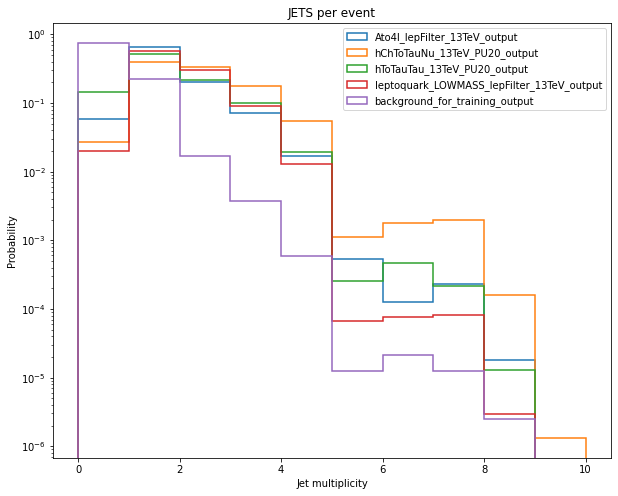

In [218]:
bin_size=10

bins = np.linspace(0, 10, 11)
plt.figure(figsize=(10,8))
for i, label in enumerate(data_labels):
    plt.hist(signals_and_bkg[i][3], bins=bins, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Jet multiplicity")
plt.ylabel("Probability")
plt.title('JETS per event')
plt.legend(loc='best')
plt.show()

In [196]:
#NLep graafik ka Nlep(muon+elektron)Ehk võtame välja  signals_and_bkg-st need ja liidame.
Nlep=[]
for i, label in enumerate(data_labels):
    a=np.array(signals_and_bkg[i][1])
    b=np.array(signals_and_bkg[i][2])
    binn=a+b
    Nlep.append(binn)
    

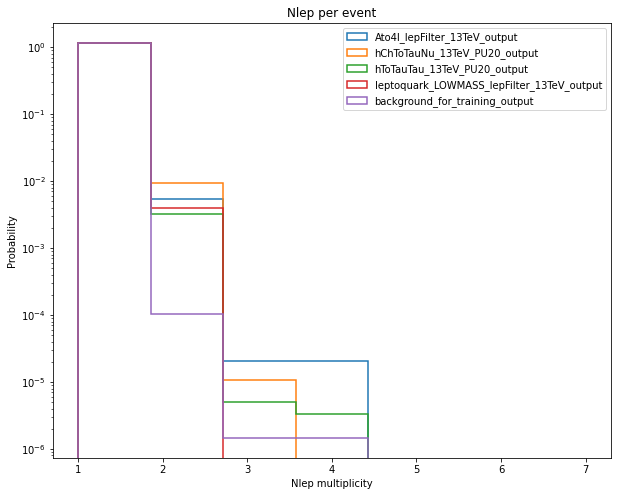

In [219]:
bins = np.linspace(1, 7, 8)
plt.figure(figsize=(10,8))
for i, label in enumerate(data_labels):
    plt.hist(Nlep[i], bins=bins, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Nlep multiplicity")
plt.ylabel("Probability")
plt.title('Nlep per event')
plt.legend(loc='best')
plt.show()

In [203]:
#Nüüd teha MET graafik phi-st sõltuvana. Phi vaja välja filtreerida per event ja signaali tüübi järgi.MET on igas 
#igas eventis ainult üks seega võtame jõuga välja
MET_phi=[]
MET_Pt=[]
for i, label in enumerate(data_labels):
    METPHI=[]
    METPT=[]
    for j in range(len(data_output[i])):
        phi=data_output[i][j][0][2]
        pt=data_output[i][j][0][0]
        METPHI.append(phi)
        METPT.append(pt)
        
    MET_phi.append(METPHI)
    MET_Pt.append(METPT)
    

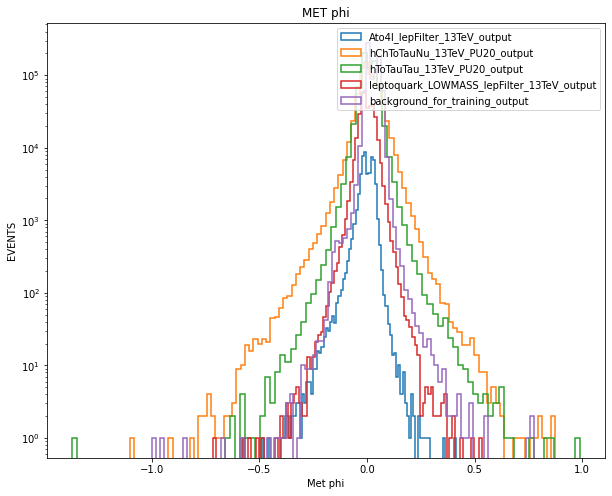

In [204]:
bin_size=100
plt.figure(figsize=(10,8))
for i, label in enumerate(data_labels):
    plt.hist(MET_phi[i], bins=bin_size, label=label, histtype='step', fill=False, linewidth=1.5,log=True)
plt.yscale('log')
plt.xlabel("Met phi")
plt.ylabel("EVENTS")
plt.title('MET phi')
plt.legend(loc='best')
plt.show()

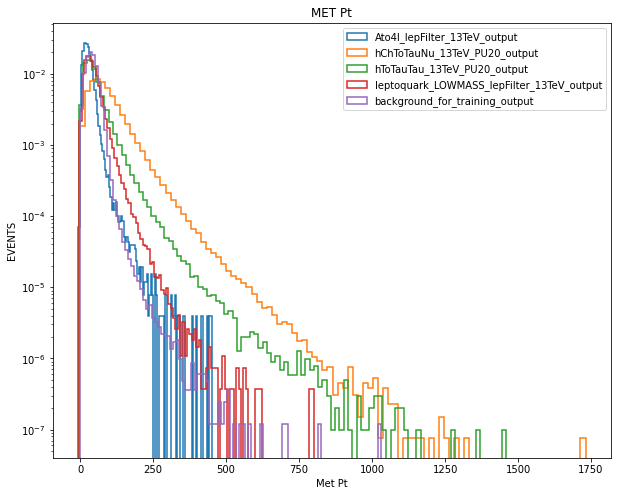

In [217]:
bin_size=100
plt.figure(figsize=(10,8))
for i, label in enumerate(data_labels):
    plt.hist(MET_Pt[i], bins=bin_size, density=True,label=label, histtype='step', fill=False, linewidth=1.5,log=True)
plt.yscale('log')
plt.xlabel("Met Pt")
plt.ylabel("EVENTS")
plt.title('MET Pt')
plt.legend(loc='best')
plt.show()

Save reults

In [179]:
save_file = 'DENSE_AE_OH_results'

In [180]:
with h5py.File(save_file, 'w') as file:
    file.create_dataset('BKG_input', data=X_test)
    file.create_dataset('BKG_predicted', data = bkg_prediction)
    for i, sig in enumerate(signal_results):
        file.create_dataset('%s_input' %sig[0], data=sig[1])
        file.create_dataset('%s_predicted' %sig[0], data=sig[2])

In [181]:
from func import mse_loss

In [184]:
#compute loss value (true, predicted)##1 väljund ja plot roc nr 3.
total_loss = []
total_loss.append(mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy())
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X, signal_results[i][2].astype(np.float32)).numpy())

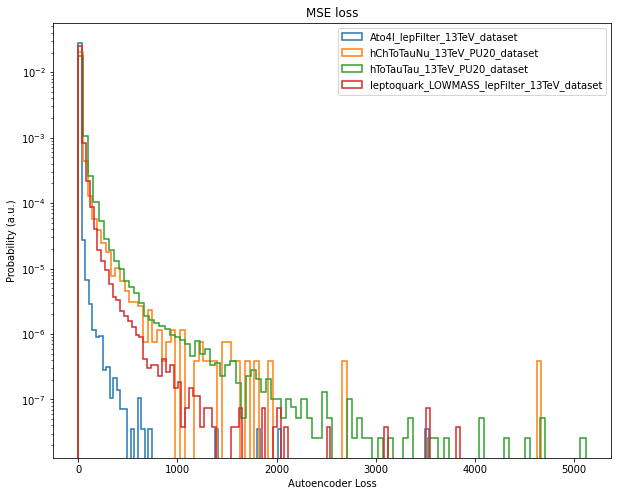

In [220]:
bin_size=100

plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

In [193]:
from sklearn.metrics import roc_curve, auc

In [194]:
labels = np.concatenate([['Background'], np.array(signal_labels)])

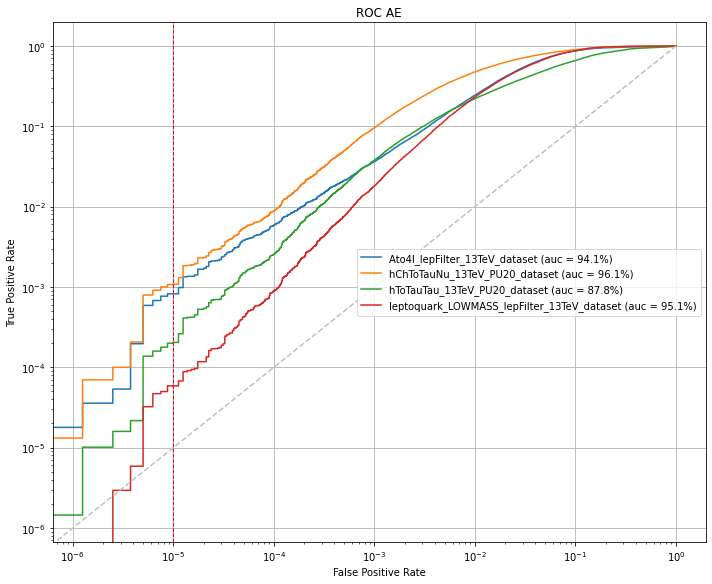

In [195]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()